In [5]:
import pandas as pd
import numpy as np
import logging
from scripts.models.agent import Agent
from scripts.models.parameters import Parameters
import scripts.main as main
import plotly.graph_objects as go
import plotly
import random
from plotly.subplots import make_subplots  
import os
from datetime import datetime
from collections import defaultdict

In [15]:
def add_error(df, column_name, num):
    df["Mean"] = df.mean(axis=1)
    for i in range(num):
        df[f"{column_name}_{i}_sqr"] = np.power(df[f"{column_name}_{i}"] - df[f"Mean"], 2)
    df["Error"] = np.sqrt(sum([df[f"{column_name}_{i}_sqr"] for i in range(num)])/num)
    return df

In [16]:
def logging_custom():
    DEFAULT_CACHE_PATH = "cache/"
    DEFAULT_LOGGS_PATH = DEFAULT_CACHE_PATH + "logs/"
    loggs_id = max(os.listdir(DEFAULT_LOGGS_PATH))
    loggs_path = DEFAULT_LOGGS_PATH + f"{int(loggs_id) + 1}/"
    os.mkdir(loggs_path)
    return loggs_path

In [6]:
generate = True
num_agents = 10

# logging.basicConfig(filename=f'{logging_custom()}_loggs_lvp.log', filemode='w', level=logging.INFO, force=True)
productivities = [100] * num_agents
num_steps = 30

pars = Parameters()
pars.n = num_agents

probability = 0.5

def is_neib(i, j):
    rand = random.random()

    if abs(i - j) == 1:
        return 1

    if rand < probability:
        return 1
    
    return 0
    

Adj = np.matrix([[is_neib(i, j) for i in range(num_agents)] for j in range(num_agents)])
print(Adj)
W = Adj / 2
# Adj = np.array([
#         [0, 0, 1, 1, 0],
#         [0, 0, 0, 1, 1],
#         [1, 0, 0, 0, 1],
#         [1, 1, 0, 0, 0],
#         [0, 1, 1, 0, 0]
#     ])
# W = Adj / 2
pars.b = W

pars.neib_add = 5
pars.add_neib_val = 0.5

# L_sub =  max([sum([W[i, j] * W[i, j] for j in range(num_agents)])/productivities[i]**4 for i in range(num_agents)])
# L = np.sqrt((num_agents + 1) * L_sub)

# mu = min([sum(W[i].A1)/productivities[i]**2 for i in range(num_agents)])

pr = max([productivities[agent] for agent in range(num_agents)])
L = (0.5*0.5 * 2) * (num_agents + 1) / pr
mu = 0.9
h = 0.002
eta = 0.8
alpha = [0.0001, 0.003, 0.011][1]
gamma = [[0.007, 0.009, 0.011][0]]

# h = 0.2
# eta = 0
# alpha = [0.07, 0.09, 0.11][2]
# gamma = [[0.07, 0.09, 0.11, 0.4][3]]

pars.params_dict = {
    "L": L,
    "mu": mu,
    "h": h,
    "eta": eta,
    "gamma": gamma,
    "alpha": alpha
}

print(pars.params_dict)


# gamma.append((1 - alpha) * gamma[0] + alpha * (mu - eta))
# H = h - h * h * L / 2
# H - alpha * alpha / (2 * gamma[1]) #should be more than zero

[[0 1 1 1 0 0 1 1 1 1]
 [1 1 1 1 1 1 0 0 0 1]
 [0 1 0 1 1 0 1 0 0 0]
 [0 1 1 1 1 1 0 1 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 1 1 1 1 1 0 1 1]
 [0 0 1 0 1 1 1 1 0 1]
 [0 0 1 0 1 0 1 1 1 0]
 [0 0 1 0 0 0 0 1 0 1]
 [1 0 0 0 0 1 0 1 1 1]]
{'L': 0.055, 'mu': 0.9, 'h': 0.002, 'eta': 0.8, 'gamma': [0.007], 'alpha': 0.003}


In [18]:
d_max = 3
1/d_max

0.3333333333333333

In [19]:
today = datetime.today().strftime('%Y-%m-%d')

In [7]:
exp = 1
iter_past = 0

In [8]:
def plot(seq_df, num_agents, alg):
    """ Plot queue length dynamics """
    global k, exp
    
    layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
    fig = make_subplots(rows=2, cols=1)

    for i in range(num_agents):
        sequence = seq_df[f"Agent_{i}"]
        fig.add_trace(go.Scatter(y=sequence,          
                                 x=list(range(len(sequence))),
                                             name=f"Agent {i} {alg}",
                                             mode="lines"),
                     row=1, col=1)

    fig.update_layout(
        xaxis_title="t",
        yaxis_title="Queue length",
        font = dict(size = 20),
        height=600,
    )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
    fig.show()

    fig.write_html(f"./trash/trash_{k}_{exp}_{alg}_seq.html");
    
def run(is_evaluate, algorithm, num_agents, num_steps, pars, generate, productivities, ret_alg=False):
    global k, exp
    
    alg = None
    if is_evaluate:
        print(algorithm)
        alg = main.run_load_balancing(algorithm, num_steps, pars, generate, productivities=productivities)
    
        print(algorithm)
        alg_seq = alg.sequence
        seq_df = pd.DataFrame(alg_seq, columns=[f"Agent_{ind}" for ind in range(num_agents)])
        
        plot(seq_df, num_agents, alg=algorithm)
        
        seq_df = add_error(seq_df, "Agent", num_agents);
        seq_df.to_csv(f"./trash/seq/{exp}_{k}_{algorithm}_seq.html")
    else:
        seq_df = pd.read_csv(f"./trash/seq/{exp}_{k}_{algorithm}_seq.html")
        print(f"Added seq_df")
    
    if ret_alg:
        return alg, seq_df
    return None, seq_df

In [23]:
itr = 1
start = -1
iter_past = 0

for k in range(iter_past, itr):
    # Run LVP and extract sequnce
    do = k > start
    alg_lvp, lvp_seq = run(do, main.LVP, num_agents, num_steps, pars, True, productivities, ret_alg=True) 

    # Run ALVP
    do = k > start
    alg_alvp, alvp_seq = run(do, main.ALVP, num_agents, num_steps, pars, False, productivities, ret_alg=True) 

    # Run RR
    do = k > start
    alg_rr, rr_seq = run(do, main.ROUND_ROBIN, num_agents, num_steps, pars, False, productivities, ret_alg=True) 
    
    # Plot error plot
    layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
    fig = go.Figure(layout=layout)

    fig.add_trace(go.Scatter(y=lvp_seq["Error"],
                                         x=list(range(len(lvp_seq))),
                                         name=f"Error LVP",
                                         mode="lines",
                            line={'dash': 'dot', 'color': 'red'}))

    fig.add_trace(go.Scatter(y=alvp_seq["Error"],
                                 x=list(range(len(alvp_seq))),
                                 name=f"Error ALVP",
                                 mode="lines",
                            line={'dash': 'solid', 'color': 'green'}))


    fig.add_trace(go.Scatter(y=rr_seq["Error"],
                                 x=list(range(len(rr_seq))),
                                 name=f"Error RR",
                                 mode="lines",
                            line={'dash': 'solid', 'color': 'blue'}))


    fig.update_layout(
        xaxis_title="t",
        yaxis_title="Error",
        legend = dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.9
        ),
        font = dict(size = 20),
        height=800
    )
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
    fig.show()

    fig.write_html(f"./trash/trash_{k}_{exp}_error.html");

    # if k > 0:
    #     alvp_er[f"Error_{k}"] = alvp_seq
    #     lvp_er[f"Error_{k}"] = lvp_seq
    #     rr_er[f"Error_{k}"] = rr_seq
    # else:
    #     alvp_er = pd.DataFrame(alvp_seq, columns=["Error_0"])
    #     lvp_er = pd.DataFrame(lvp_seq, columns=["Error_0"])
    #     rr_er = pd.DataFrame(rr_seq, columns=["Error_0"])
    
    # alvp_er.to_csv(f"~/Load_Balancing_numpy/trash/exp_{exp}_{today}_alvp.csv")
    # lvp_er.to_csv(f"~/Load_Balancing_numpy/trash/exp_{exp}_{today}_lvp.csv")
    # rr_er.to_csv(f"~/Load_Balancing_numpy/trash/exp_{exp}_{today}_rr.csv")
            
    
print("Finish")
iter_past = k

LVP
Step 0 is completed
Step 1 is completed
Step 2 is completed
Step 3 is completed
Step 4 is completed
Step 5 is completed
Step 6 is completed
Step 7 is completed
Step 8 is completed
Step 9 is completed
Step 10 is completed
Step 11 is completed
Step 12 is completed
Step 13 is completed
Step 14 is completed
Step 15 is completed
Step 16 is completed
Step 17 is completed
Step 18 is completed
Step 19 is completed
Step 20 is completed
Step 21 is completed
Step 22 is completed
Step 23 is completed
Step 24 is completed
Step 25 is completed
Step 26 is completed
Step 27 is completed
Step 28 is completed
Step 29 is completed
LVP


ALVP
Step 0 is completed
Step 1 is completed
Step 2 is completed
Step 3 is completed
Step 4 is completed
Step 5 is completed
Step 6 is completed
Step 7 is completed
Step 8 is completed
Step 9 is completed
Step 10 is completed
Step 11 is completed
Step 12 is completed
Step 13 is completed
Step 14 is completed
Step 15 is completed
Step 16 is completed
Step 17 is completed
Step 18 is completed
Step 19 is completed
Step 20 is completed
Step 21 is completed
Step 22 is completed
Step 23 is completed
Step 24 is completed
Step 25 is completed
Step 26 is completed
Step 27 is completed
Step 28 is completed
Step 29 is completed
ALVP


ROUND_ROBIN
Step 0 is completed
Step 1 is completed
Step 2 is completed
Step 3 is completed
Step 4 is completed
Step 5 is completed
Step 6 is completed
Step 7 is completed
Step 8 is completed
Step 9 is completed
Step 10 is completed
Step 11 is completed
Step 12 is completed
Step 13 is completed
Step 14 is completed
Step 15 is completed
Step 16 is completed
Step 17 is completed
Step 18 is completed
Step 19 is completed
Step 20 is completed
Step 21 is completed
Step 22 is completed
Step 23 is completed
Step 24 is completed
Step 25 is completed
Step 26 is completed
Step 27 is completed
Step 28 is completed
Step 29 is completed
ROUND_ROBIN


Finish


In [67]:
fig.write_html(f"./pictures/concrete_example_{2}.html");

In [28]:
len([task for agent in alg_lvp.agents for task in agent.all_tasks if task.step == 0 and not task.completed_step])

159

In [29]:
res_completed_step = defaultdict(lambda: [])
for agent in alg_alvp.agents:
    for task in agent.all_tasks:
        res_completed_step[task.step].append(task.completed_step)
    
result_dict = {}
for step, completed_steps in res_completed_step.items():
    if not completed_steps:
        continue
        
    result_dict[step] = {"min_compl_step": min(completed_steps), "mean_compl_step": np.mean(completed_steps), "max_compl_step": max(completed_steps)}
result_dict

{0: {'min_compl_step': 0,
  'mean_compl_step': 8.606798866855524,
  'max_compl_step': 18},
 1: {'min_compl_step': 17, 'mean_compl_step': 17.0, 'max_compl_step': 17},
 2: {'min_compl_step': 17, 'mean_compl_step': 17.0, 'max_compl_step': 17},
 3: {'min_compl_step': 17, 'mean_compl_step': 17.0, 'max_compl_step': 17},
 7: {'min_compl_step': 17,
  'mean_compl_step': 17.333333333333332,
  'max_compl_step': 18},
 9: {'min_compl_step': 17, 'mean_compl_step': 17.4, 'max_compl_step': 18},
 10: {'min_compl_step': 18, 'mean_compl_step': 18.0, 'max_compl_step': 18},
 13: {'min_compl_step': 18, 'mean_compl_step': 18.0, 'max_compl_step': 18},
 15: {'min_compl_step': 18, 'mean_compl_step': 18.0, 'max_compl_step': 18},
 17: {'min_compl_step': 18, 'mean_compl_step': 18.0, 'max_compl_step': 18},
 18: {'min_compl_step': 18, 'mean_compl_step': 18.0, 'max_compl_step': 18},
 19: {'min_compl_step': 19, 'mean_compl_step': 19.0, 'max_compl_step': 19},
 22: {'min_compl_step': 22, 'mean_compl_step': 22.0, 'max_co

In [30]:
pd.DataFrame(result_dict).transpose()

,min_compl_step,mean_compl_step,max_compl_step
0,0.0,8.606799,18.0
1,17.0,17.000000,17.0
2,17.0,17.000000,17.0
3,17.0,17.000000,17.0
7,17.0,17.333333,18.0
...,...,...,...
50,50.0,50.000000,50.0
52,52.0,52.000000,52.0
55,55.0,55.000000,55.0
56,56.0,56.000000,56.0


In [31]:
res = {}
for step in range(num_steps):
    durs = [task.completed_step for agent in alg_lvp.agents for task in agent.all_tasks if task.step == step and task.completed_step]
    if not durs:
        continue
    res[step] = {"min": min(durs), "mean": np.mean(durs), "max": max(durs)}
res

{0: {'min': 1, 'mean': 9.060812815188372, 'max': 19},
 1: {'min': 16, 'mean': 16.0, 'max': 16},
 2: {'min': 16, 'mean': 16.0, 'max': 16},
 3: {'min': 16, 'mean': 16.0, 'max': 16},
 4: {'min': 16, 'mean': 16.0, 'max': 16},
 5: {'min': 16, 'mean': 16.0, 'max': 16},
 7: {'min': 16, 'mean': 16.333333333333332, 'max': 17},
 8: {'min': 16, 'mean': 16.0, 'max': 16},
 9: {'min': 16, 'mean': 16.4, 'max': 17},
 10: {'min': 17, 'mean': 17.0, 'max': 17},
 11: {'min': 17, 'mean': 17.0, 'max': 17},
 13: {'min': 17, 'mean': 17.0, 'max': 17},
 14: {'min': 17, 'mean': 17.0, 'max': 17},
 15: {'min': 17, 'mean': 17.0, 'max': 17},
 16: {'min': 17, 'mean': 17.0, 'max': 17},
 17: {'min': 17, 'mean': 17.0, 'max': 17},
 18: {'min': 18, 'mean': 18.0, 'max': 18},
 19: {'min': 19, 'mean': 19.0, 'max': 19},
 20: {'min': 20, 'mean': 20.0, 'max': 20},
 22: {'min': 22, 'mean': 22.0, 'max': 22},
 23: {'min': 23, 'mean': 23.0, 'max': 23},
 24: {'min': 24, 'mean': 24.0, 'max': 24},
 25: {'min': 25, 'mean': 25.0, 'max':

In [33]:
layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(y=lvp_seq["Error"],
                                     x=list(range(len(lvp_seq))),
                                     name=f"Error LVP",
                                     mode="lines",
                        line={'dash': 'dot', 'color': 'red'}))

fig.add_trace(go.Scatter(y=alvp_seq["Error"],
                             x=list(range(len(alvp_seq))),
                             name=f"Error ALVP",
                             mode="lines",
                        line={'dash': 'solid', 'color': 'green'}))



fig.update_layout(
    xaxis_title="t",
    yaxis_title="Error",
    legend = dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.9
    ),
    font = dict(size = 20)
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()
fig.write_html(f"./trash/trash_{k}_{exp}_error.html");

if k > 0:
    alvp_er[f"Error_{k}"] = alvp_seq
    lvp_er[f"Error_{k}"] = lvp_seq
else:
    alvp_er = pd.DataFrame(alvp_seq, columns=["Error_0"])
    lvp_er = pd.DataFrame(lvp_seq, columns=["Error_0"])

alvp_er.to_csv(f"./trash/exp_{exp}_{today}_alvp.csv")
lvp_er.to_csv(f"./trash/exp_{exp}_{today}_lvp.csv")

In [34]:
exp = 1

In [36]:
layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = make_subplots(rows=2, cols=1)

for i in range(num_agents):
    sequence = [j[i] for j in alg_lvp.sequence]
    fig.add_trace(go.Scatter(y=sequence,          
                             x=list(range(len(sequence))),
                                         name=f"Agent {i} LVP",
                                         mode="lines"),
                 row=1, col=1)
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20),
    # width=800,
    height=600,
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

In [37]:
pr = max([max(agent.prods) for agent in agents])
L = (0.5*0.5 * 2) * (num_agents + 1) / pr
L

NameError: name 'agents' is not defined

In [13]:
res = {}
params = {}
indx = -1

In [14]:
generate = False

def run(mu, eta, alpha, gamma, name, pars):
    # logging.basicConfig(filename=f'{logging_custom()}_loggs_lvp.log', filemode='w', level=logging.INFO, force=True)
    agents = [Agent(id, productivity, generate=generate, num_steps=num_steps) for id in range(num_agents)]
    pars.params_dict = {
        "L": L,
        "mu": mu,
        "h": 0.2,
        "eta": eta,
        "gamma": gamma,
        "alpha": alpha
    }
    alg_alvp = LbAlgorithm(agents=agents, params=pars)
    alg_alvp.run(num_steps=num_steps, accelerate=True, generate_neigh=generate)
    return alg_alvp, pars.params_dict
    
gammas = [0.07, 0.1, 0.2, 0.5, 0.7, 0.9]
alphas = [0.09, 0.2, 0.5, 0.7, 0.9]

# for i in gammas:
#     for j in alphas:
#         try:
#             indx += 1
#             mu, eta = 1, 0.8
#             gamma = [i]
#             alpha = j
#             name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
#             res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)
#         except Exception as e:
#             print(e)
            
#         try:
#             indx += 1
#             mu, eta = 1, 0.9
#             gamma = [i]
#             alpha = j
#             name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
#             res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)
#         except Exception as e:
#             print(e)
        
         
#         try:
#             indx += 1
#             mu, eta = 1, 0.7
#             gamma = [i]
#             alpha = j
#             name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
#             res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)
#         except Exception as e:
#             print(e)
#         break
#     break
        
try:
    indx += 1
    mu, eta = 1, 0.8
    gamma = [[0.07, 0.09, 0.11, 0.5, 0.7, 1][0]]
    alpha = [0.07, 0.09, 0.11, 0.2, 0.3, 0.7][1]
    name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
    res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)
except:
    print("oi")

# indx += 1
# mu, eta = 1.0, 0.4
# gamma = [[0.07, 0.09, 0.11, 0.5, 0.7, 1][2]]
# alpha = [0.07, 0.09, 0.11, 0.2, 0.3, 0.7][1]
# name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
# res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)

# indx += 1
# mu, eta = 1.1, 0.7
# gamma = [[0.07, 0.09, 0.11, 0.5, 0.7, 1][2]]
# alpha = [0.07, 0.09, 0.11, 0.2, 0.3, 0.7][1]
# name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
# res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)

# indx += 1
# mu, eta = 0.9, 0.8
# gamma = [[0.07, 0.09, 0.11, 0.5][2]]
# alpha = [0.07, 0.09, 0.11, 0.2][1]
# name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
# res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)


# indx += 1
# mu, eta = 0.9, 0.7
# gamma = [[0.07, 0.09, 0.11, 0.5][0]]
# alpha = [0.07, 0.09, 0.11, 0.2][1]
# name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
# res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)

# indx += 1
# mu, eta = 0.8, 0.7
# gamma = [[0.07, 0.09, 0.11, 0.5][0]]
# alpha = [0.07, 0.09, 0.11, 0.2][1]
# name = f"{indx}_mu - eta = {round(mu - eta, 2)} gamma {gamma[0]} alpha {alpha}"
# res[name], params[name] = run(mu, eta, alpha, gamma, name, pars)

Step 0 is completed
Step 1 is completed
Step 2 is completed
Step 3 is completed
Step 4 is completed
Step 5 is completed
Step 6 is completed
Step 7 is completed
Step 8 is completed
Step 9 is completed
Step 10 is completed
Step 11 is completed
Step 12 is completed
Step 13 is completed
Step 14 is completed
Step 15 is completed
Step 16 is completed
Step 17 is completed
Step 18 is completed
Step 19 is completed
Step 20 is completed
Step 21 is completed
Step 22 is completed
Step 23 is completed
Step 24 is completed
Step 25 is completed
Step 26 is completed
Step 27 is completed
Step 28 is completed
Step 29 is completed
Step 30 is completed
Step 31 is completed
Step 32 is completed
Step 33 is completed
Step 34 is completed
Step 35 is completed
Step 36 is completed
Step 37 is completed
Step 38 is completed
Step 39 is completed
Step 40 is completed
Step 41 is completed
Step 42 is completed
Step 43 is completed
Step 44 is completed
Step 45 is completed
Step 46 is completed
Step 47 is completed
St

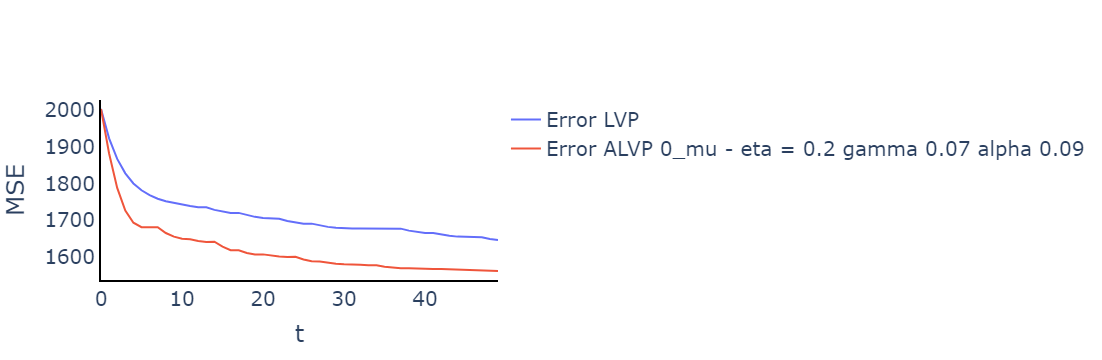

In [15]:
lvp_seq = pd.DataFrame(alg_lvp.sequence_2, columns=[f"Agent_{ind}" for ind in range(num_agents)])
add_error(lvp_seq, "Agent", num_agents);

layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(y=lvp_seq.Error,
                                     x=list(range(len(lvp_seq.Error))),
                                     name=f"Error LVP",
                                     mode="lines"))

for ind, item in res.items():
    alvp_seq = pd.DataFrame(item.sequence_2, columns=[f"Agent_{ind}" for ind in range(num_agents)])
    add_error(alvp_seq, "Agent", num_agents);
    fig.add_trace(go.Scatter(y=alvp_seq.Error,
                                         x=list(range(len(lvp_seq.Error))),
                                         name=f"Error ALVP {ind}",
                                         mode="lines"))
            
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="MSE",
    font = dict(size = 20)
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

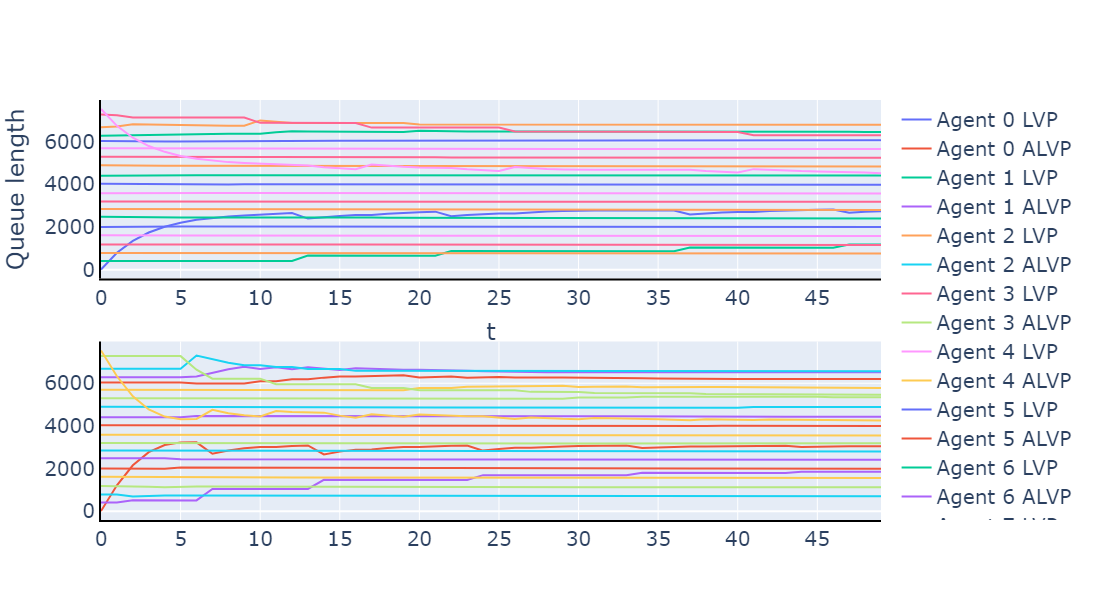

In [16]:
layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = make_subplots(rows=2, cols=1)
alg_alvp = list(res.values())[0]

for i in range(num_agents):
    sequence = [j[i] for j in alg_lvp.sequence_2]
    fig.add_trace(go.Scatter(y=sequence,
          
                             x=list(range(len(sequence))),
                                         name=f"Agent {i} LVP",
                                         mode="lines"),
                 row=1, col=1)
    
    sequence = [j[i] for j in alg_alvp.sequence_2]
    fig.add_trace(go.Scatter(y=sequence,
                                         x=list(range(len(sequence))),
                                         name=f"Agent {i} ALVP",
                                         mode="lines"),
                 row=2, col=1)
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20),
    # width=800,
    height=600,
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

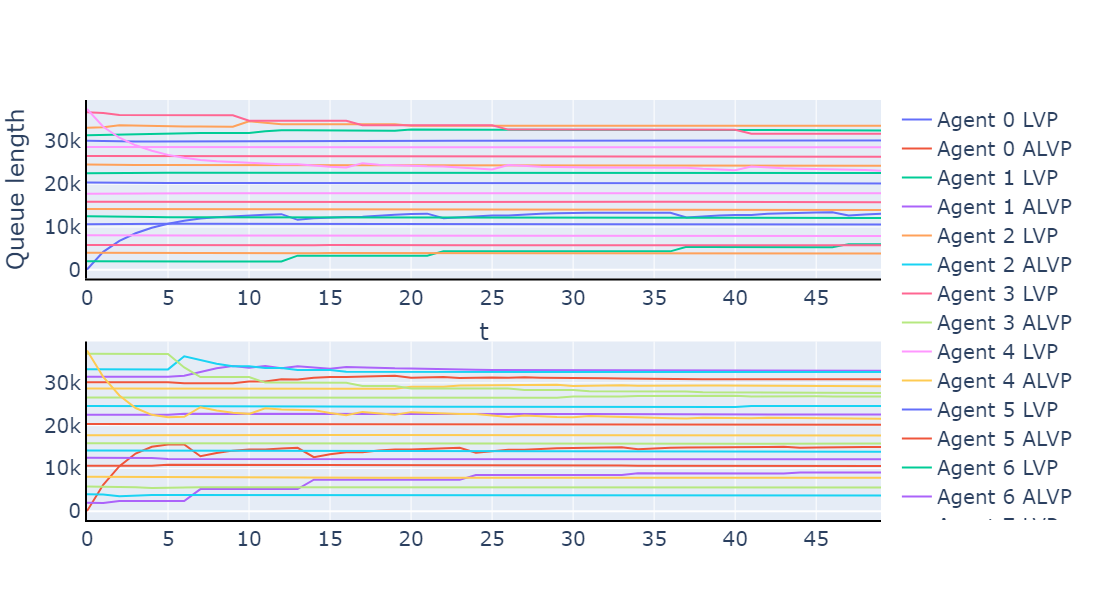

In [17]:
layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = make_subplots(rows=2, cols=1)

for i in range(num_agents):
    sequence = [j[i] for j in alg_lvp.sequence]
    fig.add_trace(go.Scatter(y=sequence,
                                         x=list(range(len(sequence))),
                                         name=f"Agent {i} LVP",
                                         mode="lines"),
                 row=1, col=1)
    
    
    sequence = [j[i] for j in alg_alvp.sequence]
    fig.add_trace(go.Scatter(y=sequence,
                                         x=list(range(len(sequence))),
                                         name=f"Agent {i} ALVP",
                                         mode="lines"),
                 row=2, col=1)
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20),
    height=600,
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

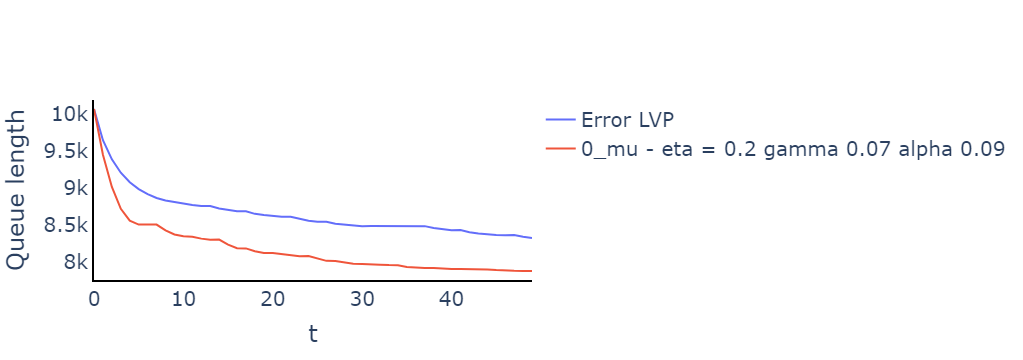

In [18]:
lvp_seq = pd.DataFrame(alg_lvp.sequence, columns=[f"Agent_{ind}" for ind in range(num_agents)])
add_error(lvp_seq, "Agent", num_agents);

layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(y=lvp_seq.Error,
                                     x=list(range(len(lvp_seq.Error))),
                                     name=f"Error LVP",
                                     mode="lines"))


for ind, item in res.items():
    alvp_seq = pd.DataFrame(item.sequence, columns=[f"Agent_{ind}" for ind in range(num_agents)])
    add_error(alvp_seq, "Agent", num_agents);

    fig.add_trace(go.Scatter(y=alvp_seq.Error,
                             x=list(range(len(lvp_seq.Error))),
                             name=f"{name}",
                             mode="lines"))

            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20)
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

In [19]:
import winsound
winsound.Beep(2200, 200)

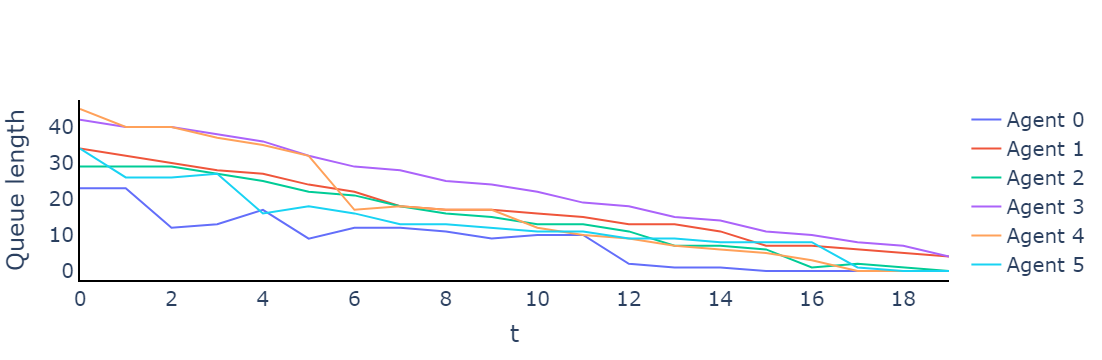

In [14]:
layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)
for i in range(number_of_agents):
    sequence = [j[i] for j in alg_alvp.sequence_2]
    fig.add_trace(go.Scatter(y=sequence,
                                         x=list(range(len(sequence))),
                                         name=f"Agent {i}",
                                         mode="lines"))
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20)
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

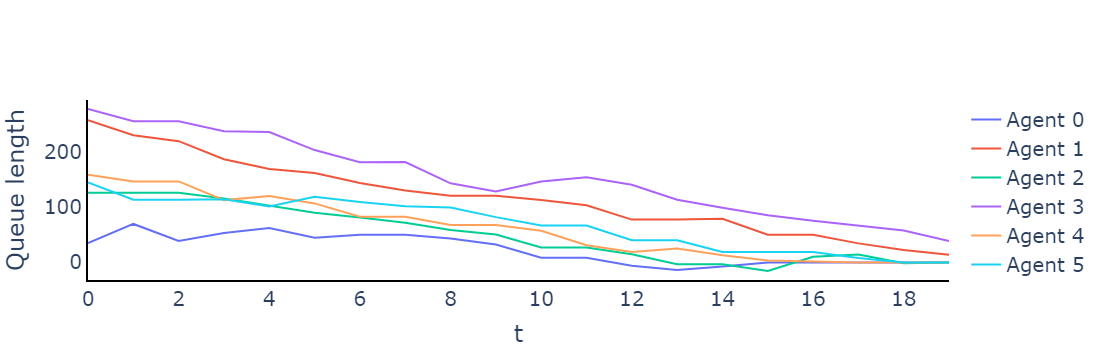

In [15]:
layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)
for i in range(number_of_agents):
    sequence = [j[i] for j in alg_alvp.sequence]
    fig.add_trace(go.Scatter(y=sequence,
                                         x=list(range(len(sequence))),
                                         name=f"Agent {i}",
                                         mode="lines"))
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20)
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

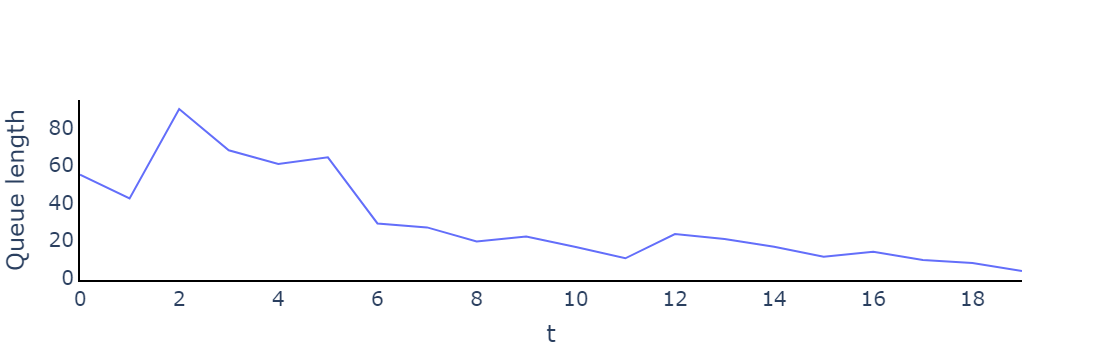

In [16]:
alvp_seq = pd.DataFrame(alg_alvp.sequence_2, columns=["Agent_0", "Agent_1", "Agent_2", "Agent_3", "Agent_4", "Agent_5"])
add_error(alvp_seq, "Agent", 6);

layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(y=alvp_seq.Error,
                                     x=list(range(len(alvp_seq.Error))),
                                     name=f"Error",
                                     mode="lines"))
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20)
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

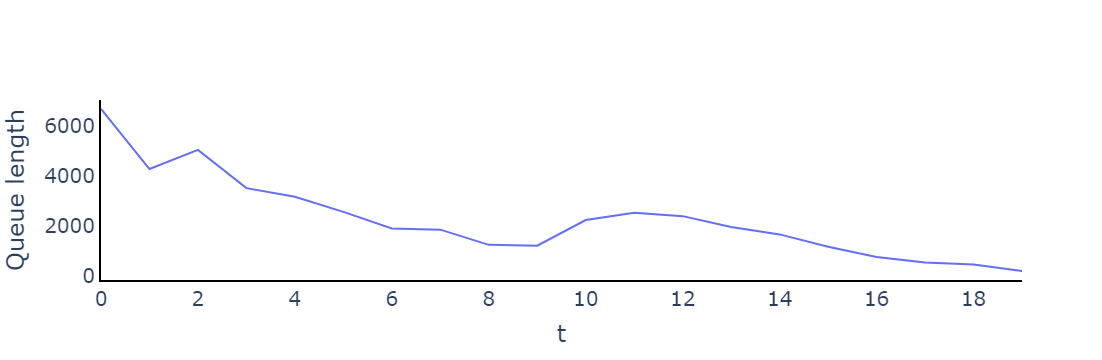

In [17]:
alvp_seq = pd.DataFrame(alg_alvp.sequence, columns=["Agent_0", "Agent_1", "Agent_2", "Agent_3", "Agent_4", "Agent_5"])
add_error(alvp_seq, "Agent", 6);

layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(y=alvp_seq.Error,
                                     x=list(range(len(alvp_seq.Error))),
                                     name=f"Error",
                                     mode="lines"))
            
fig.update_layout(
    xaxis_title="t",
    yaxis_title="Queue length",
    font = dict(size = 20)
)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='white')
fig.show()

In [28]:
%history

itr = 1
start = -1
iter_past = 0

for k in range(iter_past, itr):
    # Run LVP and extract sequnce
    do = k > start
    alg_lvp, lvp_seq = run(do, main.LVP, num_agents, num_steps, pars, False, productivities, ret_alg=True) 

    # Run ALVP
    do = k > start
    alg_alvp, alvp_seq = run(do, main.ALVP, num_agents, num_steps, pars, False, productivities, ret_alg=True) 

    # Run RR
    do = k > start
    alg_rr, rr_seq = run(do, main.ROUND_ROBIN, num_agents, num_steps, pars, False, productivities, ret_alg=True) 
    
    # Plot error plot
    layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)')
    fig = go.Figure(layout=layout)

    fig.add_trace(go.Scatter(y=lvp_seq["Error"],
                                         x=list(range(len(lvp_seq))),
                                         name=f"Error LVP",
                                         mode="lines",
                            line={'dash': 'dot', 'color': 'red'}))

    fig.add_trace(go.Scatter(y=alvp_seq["Error"],
            